# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [2]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [3]:
!mkdir data

mkdir: data: File exists


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [4]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

SVHN Training Set: 182MB [01:05, 2.78MB/s]                              
SVHN Testing Set: 64.3MB [00:22, 2.81MB/s]                              


These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [5]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

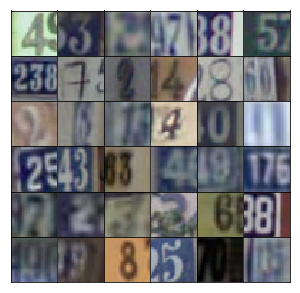

In [6]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [7]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [8]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [9]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 

>**Exercise:** Build the transposed convolutional network for the generator in the function below. Be sure to use leaky ReLUs on all the layers except for the last tanh layer, as well as batch normalization on all the transposed convolutional layers except the last one.

In [38]:
def leakyReLU(activation_fn_input, alpha=0.01):
    """
    leakyReLU is an activation function similar to ReLU, except that it doesn't make 0 the input values < 0
    Thus, this does not vanishes during gradient descent
        
    :layer_input: Input to the leaky ReLU - MUST BE A LINEAR INPUT
    :alpha      : Factor by which the values < 0 will be reduced instead of being 0 as in a regular ReLU function
    
    Example: if input=-1, alpha=0.1 in
                Regular ReLU the output will be 0 since -1<0
                Leaky ReLU the output will be max(0.1*-1, -1). In this case -0.1 is the output as -1<-0.1
    """
    return tf.maximum(alpha*activation_fn_input, activation_fn_input)

def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        depth = 512 #1024
        x = tf.contrib.layers.fully_connected(z, 2*2*depth, activation_fn=None)
        # flatten the layer
        x_flat = tf.reshape(x,(-1,2,2,depth))
        
        # convolutional layers
        #1ST Layer
        # upsample
        #upsample1 = tf.image.resize_nearest_neighbor(x_flat,[2,2])
        # convolution
        #conv1_linear = tf.layers.conv2d(upsample1,1024,(3,3),padding='same')
        # batch normalization
        #conv1_batch_norm = tf.layers.batch_normalization(conv1_linear, training=training)
        # leaky ReLU
        #conv1 = leakyReLU(conv1_batch_norm, alpha=alpha)
        
        #2ND Layer
        #upsample2 = tf.image.resize_nearest_neighbor(conv1,[4,4])
        upsample2 = tf.image.resize_nearest_neighbor(x_flat,[4,4])
        
        conv2_linear = tf.layers.conv2d(upsample2,512,(3,3),padding='same')
        
        conv2_batch_norm = tf.layers.batch_normalization(conv2_linear, training=training)
        
        conv2 = leakyReLU(conv2_batch_norm,alpha=alpha)
        
        #3RD Layer
        upsample3 = tf.image.resize_nearest_neighbor(conv2,[8,8])
        
        conv3_linear = tf.layers.conv2d(upsample3,256,(3,3), padding='same')
        
        conv3_batch_norm = tf.layers.batch_normalization(conv3_linear, training=training)
        
        conv3 = leakyReLU(conv3_batch_norm,alpha=alpha)
        
        #4TH Layer
        upsample4 = tf.image.resize_nearest_neighbor(conv3,[16,16])
        
        conv4_linear = tf.layers.conv2d(upsample4,128,(3,3), padding='same')
        
        conv4_batch_norm = tf.layers.batch_normalization(conv4_linear, training=training)
        
        conv4 = leakyReLU(conv4_batch_norm, alpha=alpha)
        
        #5TH Layer
        upsample5 = tf.image.resize_nearest_neighbor(conv4,[32,32])
        
        conv5_linear = tf.layers.conv2d(upsample5,output_dim,(3,3), padding='same')
        
        #conv5_batch_norm = tf.layers.batch_normalization(conv5_linear,training=training)
        
        #conv5 = leakyReLU(conv5_batch_norm,alpha=alpha)
        
        # Output layer, 32x32x3
        logits = conv5_linear
        
        out = tf.tanh(logits)
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've built before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

>**Exercise:** Build the convolutional network for the discriminator. The input is a 32x32x3 images, the output is a sigmoid plus the logits. Again, use Leaky ReLU activations and batch normalization on all the layers except the first.

In [39]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        training = True # harcoded to True since the discriminator is actually only used for training.
                        # the generator is the only one that does the inference (creates new images)
        
        # Input layer is 32x32x3
        conv1_linear = tf.layers.conv2d(x, 64, (16,16), padding='same')
        conv1 = leakyReLU(conv1_linear,alpha=alpha)
        
        #2ND Layer
        conv2_linear = tf.layers.conv2d(conv1, 128, (8,8), padding='same')
        conv2_batch_norm = tf.layers.batch_normalization(conv2_linear, training=training)
        conv2 = leakyReLU(conv2_batch_norm, alpha=alpha)
        
        #3RD Layer
        conv3_linear = tf.layers.conv2d(conv2, 256, (4,4), padding='same')
        conv3_batch_norm = tf.layers.batch_normalization(conv3_linear, training=training)
        conv3 = leakyReLU(conv3_batch_norm, alpha=alpha)
        
        #4TH Layer
        #conv4_linear = 
        
        #flatten
        conv_flat = tf.reshape(conv3,(-1,4*4*256))
        
        
        logits = tf.contrib.layers.fully_connected(conv_flat,1,activation_fn=None)
        out = tf.nn.sigmoid(logits,name='output')
        
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [40]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [41]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [42]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=0.2)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

Here is a function for displaying generated images.

In [43]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [44]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

>**Exercise:** Find hyperparameters to train this GAN. The values found in the DCGAN paper work well, or you can experiment on your own. In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [45]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0002 #0.0002 #0.001
batch_size = 64
epochs = 2
alpha = 0.2 #0.2 #0.01
beta1 = 0.5 #0.5 #0.9

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/2... Discriminator Loss: 1.4266... Generator Loss: 0.6572
Epoch 1/2... Discriminator Loss: 1.4924... Generator Loss: 0.6701
Epoch 1/2... Discriminator Loss: 1.1604... Generator Loss: 1.0003
Epoch 1/2... Discriminator Loss: 1.0534... Generator Loss: 1.1514
Epoch 1/2... Discriminator Loss: 1.3897... Generator Loss: 0.6197
Epoch 1/2... Discriminator Loss: 0.9626... Generator Loss: 0.9909
Epoch 1/2... Discriminator Loss: 1.2333... Generator Loss: 0.6322
Epoch 1/2... Discriminator Loss: 1.3825... Generator Loss: 0.7492
Epoch 1/2... Discriminator Loss: 1.1307... Generator Loss: 0.8506
Epoch 1/2... Discriminator Loss: 0.8558... Generator Loss: 1.0697


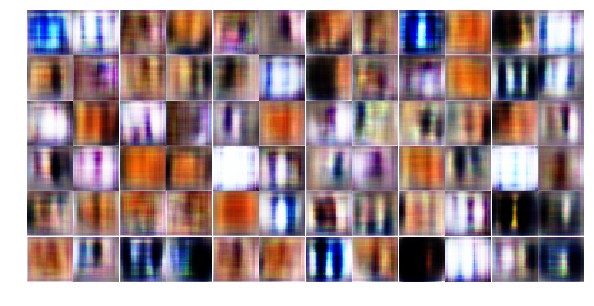

Epoch 1/2... Discriminator Loss: 1.4091... Generator Loss: 0.6303
Epoch 1/2... Discriminator Loss: 1.0079... Generator Loss: 0.9750
Epoch 1/2... Discriminator Loss: 1.0577... Generator Loss: 0.8450
Epoch 1/2... Discriminator Loss: 1.0606... Generator Loss: 1.1128
Epoch 1/2... Discriminator Loss: 0.9051... Generator Loss: 0.9985
Epoch 1/2... Discriminator Loss: 0.9700... Generator Loss: 0.9142
Epoch 1/2... Discriminator Loss: 1.0129... Generator Loss: 1.1438
Epoch 1/2... Discriminator Loss: 0.9667... Generator Loss: 0.9326
Epoch 1/2... Discriminator Loss: 1.4334... Generator Loss: 1.1770
Epoch 1/2... Discriminator Loss: 1.0783... Generator Loss: 1.0046


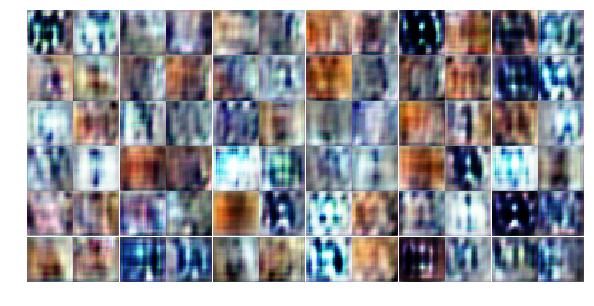

Epoch 1/2... Discriminator Loss: 1.4294... Generator Loss: 0.5014
Epoch 1/2... Discriminator Loss: 1.2697... Generator Loss: 0.7522
Epoch 1/2... Discriminator Loss: 1.3303... Generator Loss: 1.2015
Epoch 1/2... Discriminator Loss: 0.8906... Generator Loss: 0.7529
Epoch 1/2... Discriminator Loss: 0.9064... Generator Loss: 0.9120
Epoch 1/2... Discriminator Loss: 0.8111... Generator Loss: 1.3949
Epoch 1/2... Discriminator Loss: 1.0281... Generator Loss: 0.8970
Epoch 1/2... Discriminator Loss: 1.1103... Generator Loss: 1.5552
Epoch 1/2... Discriminator Loss: 1.1135... Generator Loss: 0.7618
Epoch 1/2... Discriminator Loss: 1.0862... Generator Loss: 2.0209


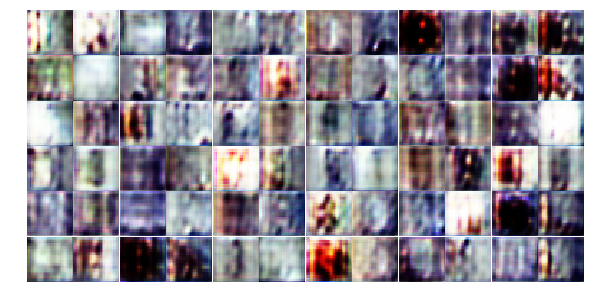

Epoch 1/2... Discriminator Loss: 1.4075... Generator Loss: 0.6627
Epoch 1/2... Discriminator Loss: 1.2013... Generator Loss: 0.6953
Epoch 1/2... Discriminator Loss: 0.9471... Generator Loss: 0.8175
Epoch 1/2... Discriminator Loss: 1.0884... Generator Loss: 1.8803
Epoch 1/2... Discriminator Loss: 0.9165... Generator Loss: 0.9906
Epoch 1/2... Discriminator Loss: 1.1105... Generator Loss: 0.8859
Epoch 1/2... Discriminator Loss: 1.4184... Generator Loss: 0.7396
Epoch 1/2... Discriminator Loss: 1.4415... Generator Loss: 0.6214
Epoch 1/2... Discriminator Loss: 1.4048... Generator Loss: 0.7218
Epoch 1/2... Discriminator Loss: 1.4250... Generator Loss: 0.6556


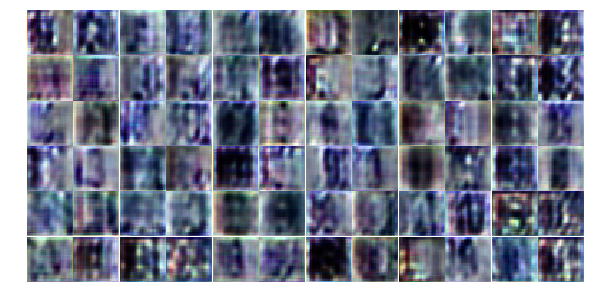

Epoch 1/2... Discriminator Loss: 1.4462... Generator Loss: 0.6925
Epoch 1/2... Discriminator Loss: 1.3362... Generator Loss: 0.8056
Epoch 1/2... Discriminator Loss: 1.4544... Generator Loss: 0.6633
Epoch 1/2... Discriminator Loss: 1.2731... Generator Loss: 0.7467
Epoch 1/2... Discriminator Loss: 1.4011... Generator Loss: 0.6934
Epoch 1/2... Discriminator Loss: 1.3271... Generator Loss: 0.6881
Epoch 1/2... Discriminator Loss: 1.4098... Generator Loss: 0.6983
Epoch 1/2... Discriminator Loss: 1.3786... Generator Loss: 0.7154
Epoch 1/2... Discriminator Loss: 1.3327... Generator Loss: 0.7743
Epoch 1/2... Discriminator Loss: 1.3419... Generator Loss: 0.7333


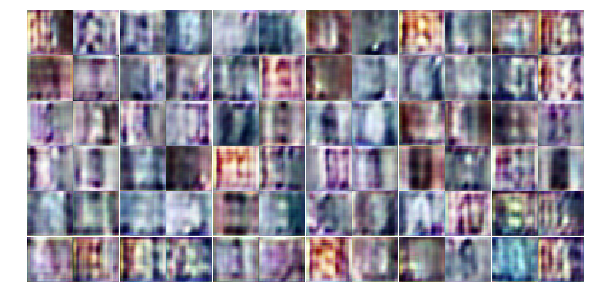

Epoch 1/2... Discriminator Loss: 1.3702... Generator Loss: 0.6308
Epoch 1/2... Discriminator Loss: 1.3771... Generator Loss: 0.6800
Epoch 1/2... Discriminator Loss: 1.3688... Generator Loss: 0.7106
Epoch 1/2... Discriminator Loss: 1.4136... Generator Loss: 0.6666
Epoch 1/2... Discriminator Loss: 1.3457... Generator Loss: 0.7019
Epoch 1/2... Discriminator Loss: 1.4023... Generator Loss: 0.6569
Epoch 1/2... Discriminator Loss: 1.3685... Generator Loss: 0.7534
Epoch 1/2... Discriminator Loss: 1.3597... Generator Loss: 0.7193
Epoch 1/2... Discriminator Loss: 1.3748... Generator Loss: 0.6596
Epoch 1/2... Discriminator Loss: 1.3784... Generator Loss: 0.7188


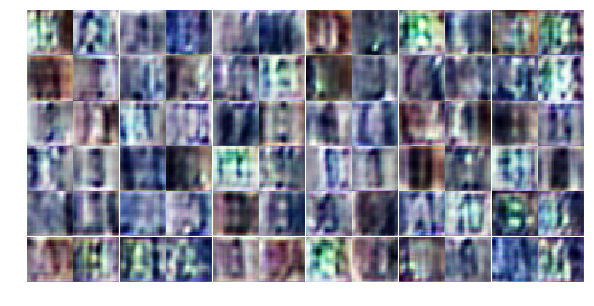

Epoch 1/2... Discriminator Loss: 1.3384... Generator Loss: 0.7271
Epoch 1/2... Discriminator Loss: 1.3609... Generator Loss: 0.7054
Epoch 1/2... Discriminator Loss: 1.3531... Generator Loss: 0.7621
Epoch 1/2... Discriminator Loss: 1.3658... Generator Loss: 0.6707
Epoch 1/2... Discriminator Loss: 1.3639... Generator Loss: 0.6858
Epoch 1/2... Discriminator Loss: 1.3788... Generator Loss: 0.7008
Epoch 1/2... Discriminator Loss: 1.4357... Generator Loss: 0.6921
Epoch 1/2... Discriminator Loss: 1.3510... Generator Loss: 0.7321
Epoch 1/2... Discriminator Loss: 1.3691... Generator Loss: 0.6897
Epoch 1/2... Discriminator Loss: 1.4249... Generator Loss: 0.6695


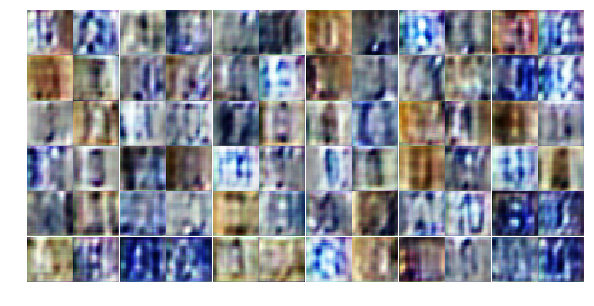

Epoch 1/2... Discriminator Loss: 1.3392... Generator Loss: 0.6827
Epoch 1/2... Discriminator Loss: 1.4002... Generator Loss: 0.7458
Epoch 1/2... Discriminator Loss: 1.3944... Generator Loss: 0.7130
Epoch 1/2... Discriminator Loss: 1.3622... Generator Loss: 0.6884
Epoch 1/2... Discriminator Loss: 1.3540... Generator Loss: 0.6836
Epoch 1/2... Discriminator Loss: 1.4326... Generator Loss: 0.7359
Epoch 1/2... Discriminator Loss: 1.2740... Generator Loss: 0.8257
Epoch 1/2... Discriminator Loss: 1.2777... Generator Loss: 0.7527
Epoch 1/2... Discriminator Loss: 1.3882... Generator Loss: 0.6778
Epoch 1/2... Discriminator Loss: 1.4216... Generator Loss: 0.7195


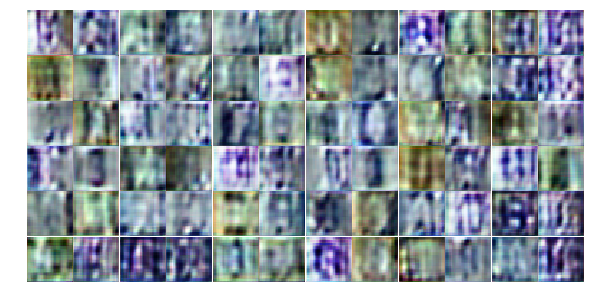

Epoch 1/2... Discriminator Loss: 1.3844... Generator Loss: 0.7409
Epoch 1/2... Discriminator Loss: 1.3877... Generator Loss: 0.6426
Epoch 1/2... Discriminator Loss: 1.3626... Generator Loss: 0.6669
Epoch 1/2... Discriminator Loss: 1.3865... Generator Loss: 0.6618
Epoch 1/2... Discriminator Loss: 1.3806... Generator Loss: 0.7426
Epoch 1/2... Discriminator Loss: 1.3887... Generator Loss: 0.7343
Epoch 1/2... Discriminator Loss: 1.3738... Generator Loss: 0.6895
Epoch 1/2... Discriminator Loss: 1.3232... Generator Loss: 0.7269
Epoch 1/2... Discriminator Loss: 1.3977... Generator Loss: 0.6611
Epoch 1/2... Discriminator Loss: 1.3841... Generator Loss: 0.6747


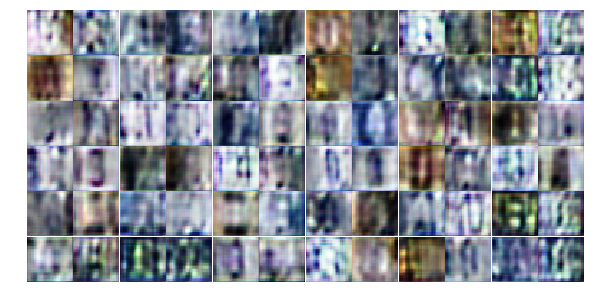

Epoch 1/2... Discriminator Loss: 1.4266... Generator Loss: 0.6615
Epoch 1/2... Discriminator Loss: 1.3623... Generator Loss: 0.7349
Epoch 1/2... Discriminator Loss: 1.3469... Generator Loss: 0.6932
Epoch 1/2... Discriminator Loss: 1.4126... Generator Loss: 0.6946
Epoch 1/2... Discriminator Loss: 1.3932... Generator Loss: 0.6522
Epoch 1/2... Discriminator Loss: 1.3531... Generator Loss: 0.6807
Epoch 1/2... Discriminator Loss: 1.3940... Generator Loss: 0.6964
Epoch 1/2... Discriminator Loss: 1.3659... Generator Loss: 0.6765
Epoch 1/2... Discriminator Loss: 1.3637... Generator Loss: 0.7216
Epoch 1/2... Discriminator Loss: 1.3695... Generator Loss: 0.7253


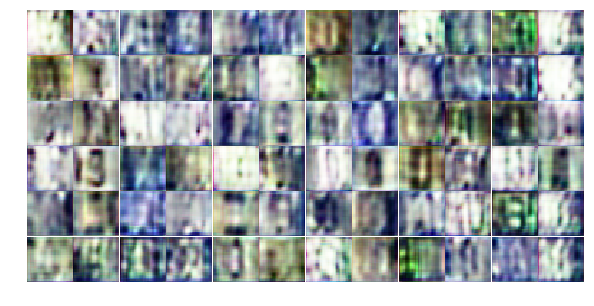

Epoch 1/2... Discriminator Loss: 1.3762... Generator Loss: 0.7442
Epoch 1/2... Discriminator Loss: 1.4011... Generator Loss: 0.6837
Epoch 1/2... Discriminator Loss: 1.3834... Generator Loss: 0.6258
Epoch 1/2... Discriminator Loss: 1.3805... Generator Loss: 0.6738
Epoch 1/2... Discriminator Loss: 1.3567... Generator Loss: 0.7486
Epoch 1/2... Discriminator Loss: 1.3450... Generator Loss: 0.6952
Epoch 1/2... Discriminator Loss: 1.4391... Generator Loss: 0.6647
Epoch 1/2... Discriminator Loss: 1.3745... Generator Loss: 0.7419
Epoch 1/2... Discriminator Loss: 1.4020... Generator Loss: 0.6618
Epoch 1/2... Discriminator Loss: 1.3727... Generator Loss: 0.6964


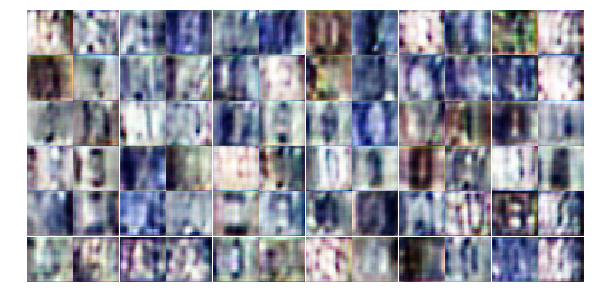

Epoch 1/2... Discriminator Loss: 1.2965... Generator Loss: 0.6835
Epoch 1/2... Discriminator Loss: 1.3837... Generator Loss: 0.7610
Epoch 1/2... Discriminator Loss: 1.4028... Generator Loss: 0.7080
Epoch 1/2... Discriminator Loss: 1.3975... Generator Loss: 0.6473
Epoch 2/2... Discriminator Loss: 1.4082... Generator Loss: 0.6685
Epoch 2/2... Discriminator Loss: 1.3706... Generator Loss: 0.6911
Epoch 2/2... Discriminator Loss: 1.4169... Generator Loss: 0.7004
Epoch 2/2... Discriminator Loss: 1.3833... Generator Loss: 0.7260
Epoch 2/2... Discriminator Loss: 1.4230... Generator Loss: 0.6870
Epoch 2/2... Discriminator Loss: 1.3954... Generator Loss: 0.6918


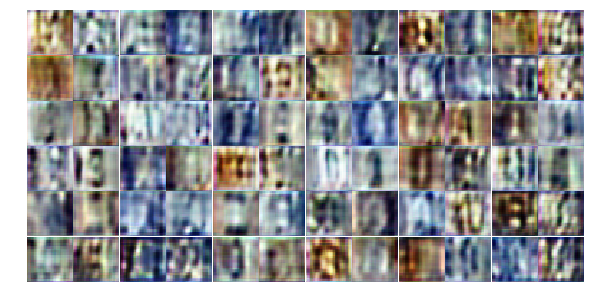

Epoch 2/2... Discriminator Loss: 1.3906... Generator Loss: 0.6866
Epoch 2/2... Discriminator Loss: 1.3885... Generator Loss: 0.6717
Epoch 2/2... Discriminator Loss: 1.4043... Generator Loss: 0.6846
Epoch 2/2... Discriminator Loss: 1.3690... Generator Loss: 0.6964
Epoch 2/2... Discriminator Loss: 1.3738... Generator Loss: 0.7222
Epoch 2/2... Discriminator Loss: 1.3885... Generator Loss: 0.6752
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.6905
Epoch 2/2... Discriminator Loss: 1.3655... Generator Loss: 0.7159
Epoch 2/2... Discriminator Loss: 1.3979... Generator Loss: 0.7031
Epoch 2/2... Discriminator Loss: 1.3784... Generator Loss: 0.7196


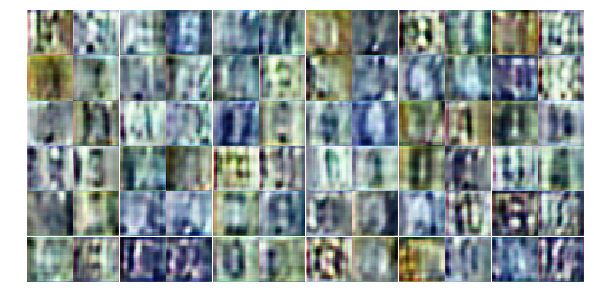

Epoch 2/2... Discriminator Loss: 1.3697... Generator Loss: 0.7073
Epoch 2/2... Discriminator Loss: 1.3765... Generator Loss: 0.6806
Epoch 2/2... Discriminator Loss: 1.3908... Generator Loss: 0.7039
Epoch 2/2... Discriminator Loss: 1.3997... Generator Loss: 0.7353
Epoch 2/2... Discriminator Loss: 1.3442... Generator Loss: 0.7170
Epoch 2/2... Discriminator Loss: 1.4892... Generator Loss: 0.6202
Epoch 2/2... Discriminator Loss: 1.3440... Generator Loss: 0.7310
Epoch 2/2... Discriminator Loss: 1.4069... Generator Loss: 0.6999
Epoch 2/2... Discriminator Loss: 1.3797... Generator Loss: 0.7273
Epoch 2/2... Discriminator Loss: 1.3831... Generator Loss: 0.6506


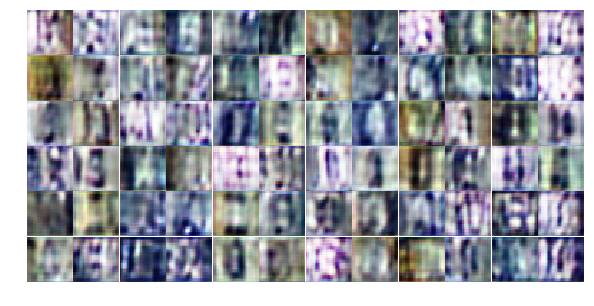

Epoch 2/2... Discriminator Loss: 1.3949... Generator Loss: 0.6954
Epoch 2/2... Discriminator Loss: 1.3838... Generator Loss: 0.7181
Epoch 2/2... Discriminator Loss: 1.3866... Generator Loss: 0.6811
Epoch 2/2... Discriminator Loss: 1.4002... Generator Loss: 0.6826
Epoch 2/2... Discriminator Loss: 1.3304... Generator Loss: 0.7177
Epoch 2/2... Discriminator Loss: 1.3897... Generator Loss: 0.7281
Epoch 2/2... Discriminator Loss: 1.3657... Generator Loss: 0.7634
Epoch 2/2... Discriminator Loss: 1.3620... Generator Loss: 0.7015
Epoch 2/2... Discriminator Loss: 1.3961... Generator Loss: 0.6527
Epoch 2/2... Discriminator Loss: 1.3962... Generator Loss: 0.6759


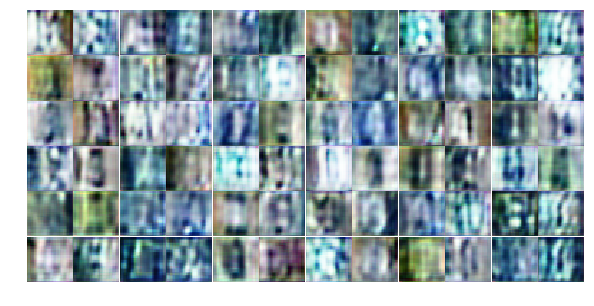

Epoch 2/2... Discriminator Loss: 1.3932... Generator Loss: 0.6721
Epoch 2/2... Discriminator Loss: 1.3356... Generator Loss: 0.7710
Epoch 2/2... Discriminator Loss: 1.4251... Generator Loss: 0.6745
Epoch 2/2... Discriminator Loss: 1.3734... Generator Loss: 0.7012
Epoch 2/2... Discriminator Loss: 1.4316... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.3800... Generator Loss: 0.7065
Epoch 2/2... Discriminator Loss: 1.3815... Generator Loss: 0.7394
Epoch 2/2... Discriminator Loss: 1.3507... Generator Loss: 0.7739
Epoch 2/2... Discriminator Loss: 1.3849... Generator Loss: 0.6665
Epoch 2/2... Discriminator Loss: 1.3509... Generator Loss: 0.6985


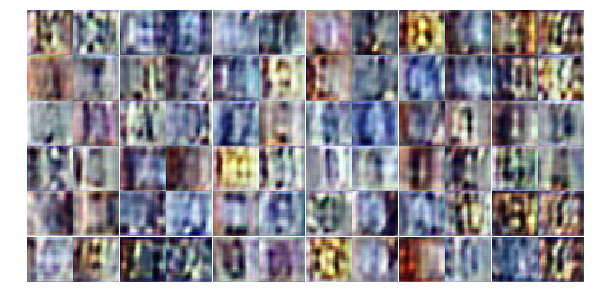

Epoch 2/2... Discriminator Loss: 1.4423... Generator Loss: 0.6986
Epoch 2/2... Discriminator Loss: 1.4044... Generator Loss: 0.7006
Epoch 2/2... Discriminator Loss: 1.3942... Generator Loss: 0.6857
Epoch 2/2... Discriminator Loss: 1.3952... Generator Loss: 0.6892
Epoch 2/2... Discriminator Loss: 1.4135... Generator Loss: 0.6877
Epoch 2/2... Discriminator Loss: 1.3635... Generator Loss: 0.7098
Epoch 2/2... Discriminator Loss: 1.3740... Generator Loss: 0.6984
Epoch 2/2... Discriminator Loss: 1.3839... Generator Loss: 0.7053
Epoch 2/2... Discriminator Loss: 1.3654... Generator Loss: 0.7050
Epoch 2/2... Discriminator Loss: 1.4063... Generator Loss: 0.7288


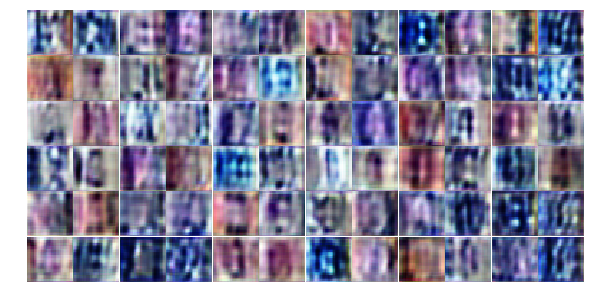

Epoch 2/2... Discriminator Loss: 1.3652... Generator Loss: 0.7703
Epoch 2/2... Discriminator Loss: 1.3997... Generator Loss: 0.6782
Epoch 2/2... Discriminator Loss: 1.3832... Generator Loss: 0.6978
Epoch 2/2... Discriminator Loss: 1.4157... Generator Loss: 0.7203
Epoch 2/2... Discriminator Loss: 1.3464... Generator Loss: 0.7358
Epoch 2/2... Discriminator Loss: 1.3812... Generator Loss: 0.7181
Epoch 2/2... Discriminator Loss: 1.3798... Generator Loss: 0.7224
Epoch 2/2... Discriminator Loss: 1.3916... Generator Loss: 0.6977
Epoch 2/2... Discriminator Loss: 1.3664... Generator Loss: 0.6788
Epoch 2/2... Discriminator Loss: 1.3703... Generator Loss: 0.7538


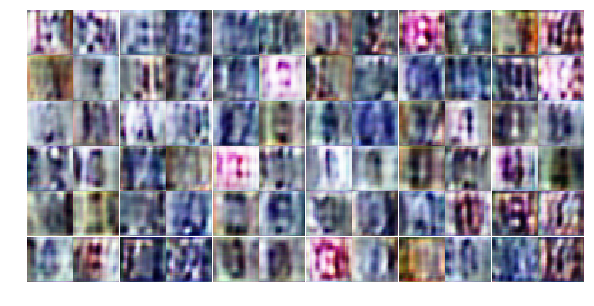

Epoch 2/2... Discriminator Loss: 1.3961... Generator Loss: 0.6961
Epoch 2/2... Discriminator Loss: 1.4020... Generator Loss: 0.6632
Epoch 2/2... Discriminator Loss: 1.3819... Generator Loss: 0.6813
Epoch 2/2... Discriminator Loss: 1.3947... Generator Loss: 0.6736
Epoch 2/2... Discriminator Loss: 1.3795... Generator Loss: 0.6635
Epoch 2/2... Discriminator Loss: 1.4010... Generator Loss: 0.7071
Epoch 2/2... Discriminator Loss: 1.3672... Generator Loss: 0.7951
Epoch 2/2... Discriminator Loss: 1.3929... Generator Loss: 0.6856
Epoch 2/2... Discriminator Loss: 1.3911... Generator Loss: 0.6804
Epoch 2/2... Discriminator Loss: 1.3048... Generator Loss: 0.7098


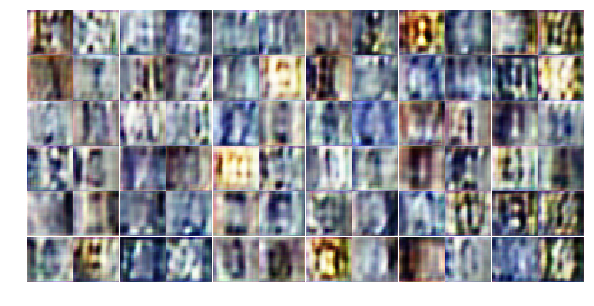

Epoch 2/2... Discriminator Loss: 1.3871... Generator Loss: 0.6286
Epoch 2/2... Discriminator Loss: 1.3995... Generator Loss: 0.6978
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.6736
Epoch 2/2... Discriminator Loss: 1.3454... Generator Loss: 0.6957
Epoch 2/2... Discriminator Loss: 1.2930... Generator Loss: 0.7147
Epoch 2/2... Discriminator Loss: 1.4261... Generator Loss: 0.7232
Epoch 2/2... Discriminator Loss: 1.3918... Generator Loss: 0.6970
Epoch 2/2... Discriminator Loss: 1.4389... Generator Loss: 0.6544
Epoch 2/2... Discriminator Loss: 1.3789... Generator Loss: 0.6994
Epoch 2/2... Discriminator Loss: 1.3712... Generator Loss: 0.7137


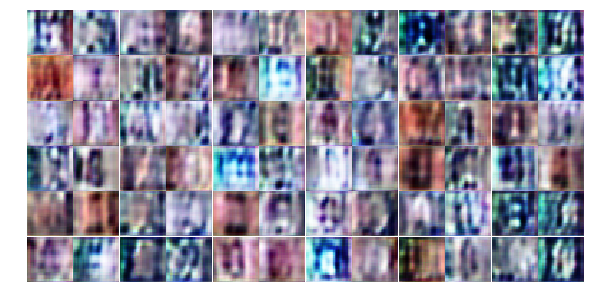

Epoch 2/2... Discriminator Loss: 1.4129... Generator Loss: 0.7068
Epoch 2/2... Discriminator Loss: 1.3677... Generator Loss: 0.7307
Epoch 2/2... Discriminator Loss: 1.4292... Generator Loss: 0.6666
Epoch 2/2... Discriminator Loss: 1.3787... Generator Loss: 0.7250
Epoch 2/2... Discriminator Loss: 1.3517... Generator Loss: 0.7198
Epoch 2/2... Discriminator Loss: 1.4098... Generator Loss: 0.7033
Epoch 2/2... Discriminator Loss: 1.3974... Generator Loss: 0.6776
Epoch 2/2... Discriminator Loss: 1.3805... Generator Loss: 0.6885
Epoch 2/2... Discriminator Loss: 1.3879... Generator Loss: 0.7030
Epoch 2/2... Discriminator Loss: 1.3733... Generator Loss: 0.6936


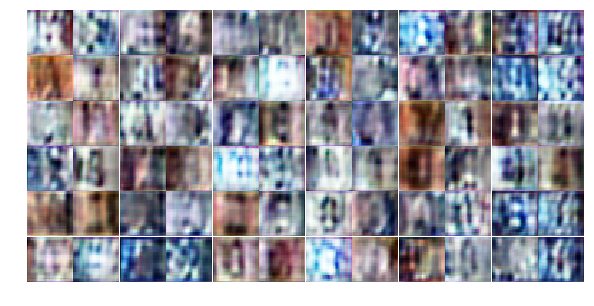

Epoch 2/2... Discriminator Loss: 1.4234... Generator Loss: 0.6757
Epoch 2/2... Discriminator Loss: 1.3714... Generator Loss: 0.6961
Epoch 2/2... Discriminator Loss: 1.3936... Generator Loss: 0.7081
Epoch 2/2... Discriminator Loss: 1.3873... Generator Loss: 0.6600
Epoch 2/2... Discriminator Loss: 1.3681... Generator Loss: 0.7004
Epoch 2/2... Discriminator Loss: 1.3713... Generator Loss: 0.7309
Epoch 2/2... Discriminator Loss: 1.3952... Generator Loss: 0.6978
Epoch 2/2... Discriminator Loss: 1.4055... Generator Loss: 0.6975
Epoch 2/2... Discriminator Loss: 1.3971... Generator Loss: 0.7100
Epoch 2/2... Discriminator Loss: 1.4011... Generator Loss: 0.6559


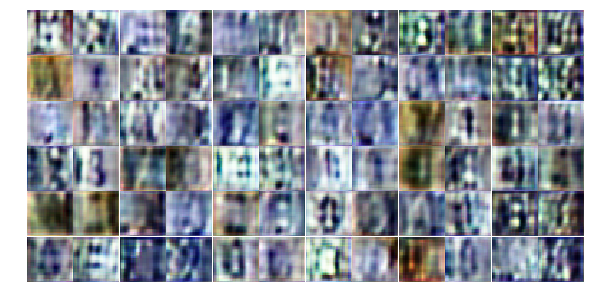

Epoch 2/2... Discriminator Loss: 1.3848... Generator Loss: 0.6687
Epoch 2/2... Discriminator Loss: 1.3931... Generator Loss: 0.6900
Epoch 2/2... Discriminator Loss: 1.3754... Generator Loss: 0.7428
Epoch 2/2... Discriminator Loss: 1.3845... Generator Loss: 0.6961
Epoch 2/2... Discriminator Loss: 1.3897... Generator Loss: 0.6596
Epoch 2/2... Discriminator Loss: 1.3921... Generator Loss: 0.7472
Epoch 2/2... Discriminator Loss: 1.3746... Generator Loss: 0.6994
Epoch 2/2... Discriminator Loss: 1.3827... Generator Loss: 0.6915
Epoch 2/2... Discriminator Loss: 1.3819... Generator Loss: 0.7200


In [46]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

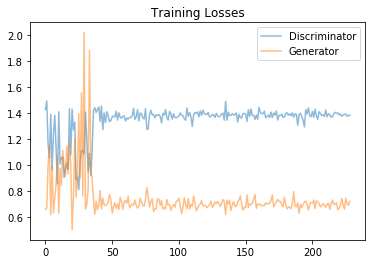

In [47]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

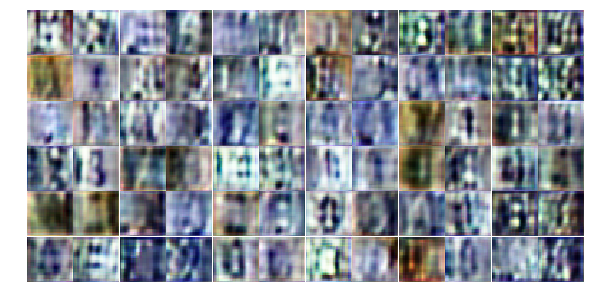

In [48]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))